In [1]:
print("""
@Title: Modeling complex time series
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-12-03 22:57:23
@Description: 
""")


@Title: Modeling complex time series
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-12-03 22:57:23
@Description: 



## Make predictions on the simulated ARMA(1,1) process

In [12]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import  adfuller
import numpy as np
import pandas as pd
np.random.seed(42)

ar1 = np.array([1, -.33])
ma1 = np.array([1, .9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1_000)

df = pd.DataFrame({'value': ARMA_1_1})
train = df[:800]
test = df[800:].copy()

In [13]:
from utils.rolling_forecast import rolling_forecast

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_arma = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'arma', order=(1, 0, 1))

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last'] = pred_last
test.loc[:, 'pred_arma'] = pred_arma

In [22]:
test.head()

,value,pred_mean,pred_last,pred_arma
800,1.084218,-0.022669,0.361071,0.146811
801,0.686203,-0.021287,1.084218,1.183808
802,-0.141873,-0.020405,0.686203,-0.255567
803,-0.422585,-0.020556,-0.141873,0.062876
804,-0.989997,-0.021056,-0.422585,-0.571610


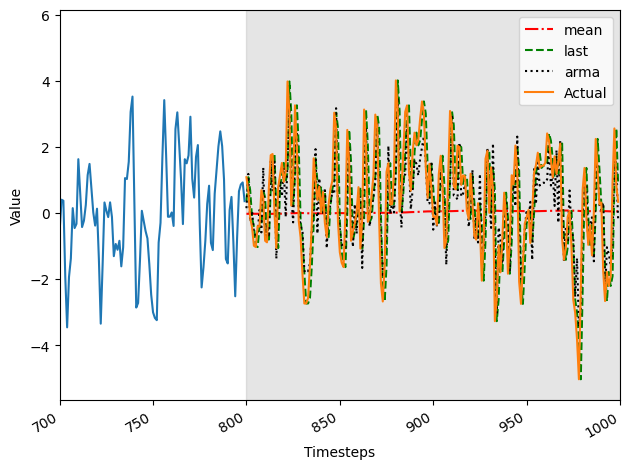

In [29]:
from utils.ts_plot import plot_pred
import matplotlib.pyplot as plt

fig, ax = plot_pred(test, ways=['mean', 'last', 'arma'])
ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

In [31]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_arma = mean_squared_error(test['value'], test['pred_arma'])

print(mse_mean, mse_last, mse_arma)

2.6792528451659092 1.6761458178498734 0.9281958689346383


## Simulate an ARMA(2,2) process and make forecasts

In [55]:
ma2 = np.array([1, .9, .3])
ar2 = np.array([1, -.33, -.5])

arma_2_2 = ArmaProcess(ar2, ma2).generate_sample(nsample=10_000)

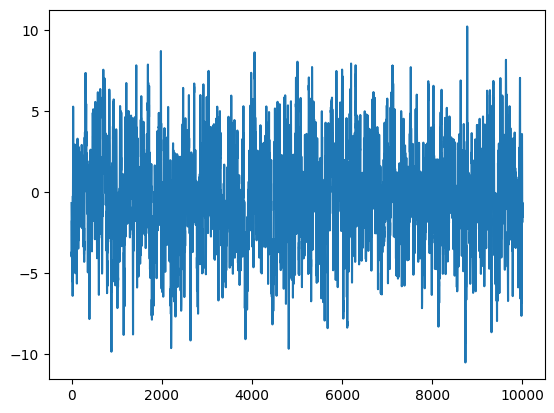

In [56]:
fig, ax = plt.subplots()
ax.plot(arma_2_2)

In [57]:
adfuller(arma_2_2)

(-20.95614213994199,
 0.0,
 5,
 9994,
 {'1%': -3.4310044907347454,
  '5%': -2.8618292459530794,
  '10%': -2.566923960483154},
 28349.752180320207)

In [58]:
df = pd.DataFrame({'value': arma_2_2})
train = df[:-200]
test = df[-200:].copy()

In [59]:
from utils.arma import optimize_arma
from itertools import  product

ps = np.arange(1, 4, 1)
qs = np.arange(1, 4, 1)

order_list = list(product(ps, qs))

result_df = optimize_arma(train['value'], order_list)
result_df

  0%|          | 0/9 [00:00<?, ?it/s]

,"(p, q)",AIC
0,"(3, 2)",27892.666922
1,"(2, 3)",27892.859111
2,"(2, 2)",27894.538521
3,"(3, 3)",27895.564287
4,"(1, 3)",27906.921171
5,"(1, 2)",27969.854880
6,"(3, 1)",27992.631159
7,"(2, 1)",28026.995963
8,"(1, 1)",28109.179373


In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['value'], order=(2, 0, 2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 9800
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13942.269
Date:                Sun, 03 Dec 2023   AIC                          27894.539
Time:                        23:23:29   BIC                          27930.489
Sample:                             0   HQIC                         27906.720
                               - 9800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3373      0.047      7.182      0.000       0.245       0.429
ar.L2          0.4803      0.043     11.093      0.000       0.395       0.565
ma.L1          0.8836      0.046     19.376      0.0

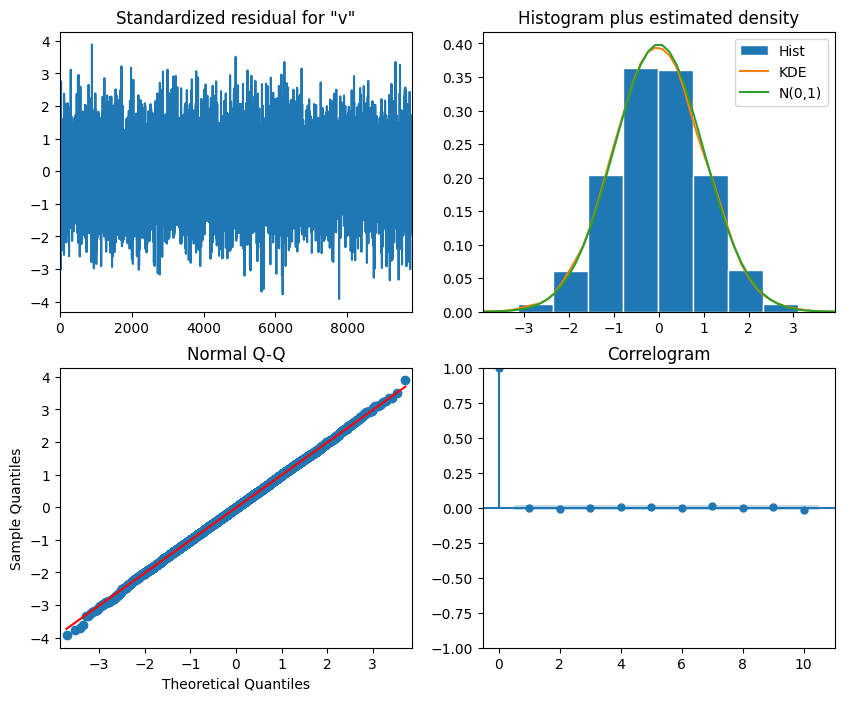

In [61]:
fig = model_fit.plot_diagnostics(figsize=(10, 8))

In [62]:
residuals = model_fit.resid

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_test

,lb_stat,lb_pvalue
1,0.090999,0.762912
2,0.830101,0.660307
3,1.109015,0.774898
4,1.682601,0.793876
5,1.870513,0.866756
6,2.019528,0.917894
7,3.514381,0.833700
8,3.797874,0.874884
9,3.835533,0.921900
10,6.097211,0.807031


In [63]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_arma = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'arma')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last'] = pred_last
test.loc[:, 'pred_arma'] = pred_arma

In [65]:
test.loc[:, 'pred_arma'] = pred_arma

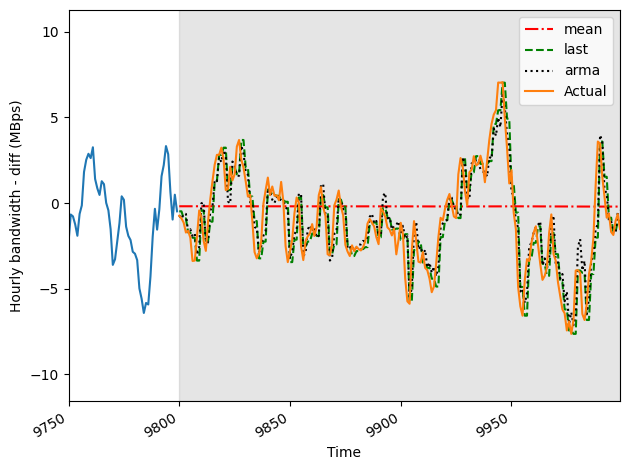

In [70]:
fig, ax = plot_pred(test, ways=['mean', 'last', 'arma'])
ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend()

ax.axvspan(9800, 9999, color='#808080', alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.set_xlim(9750, 9999)

fig.autofmt_xdate()
plt.tight_layout()

In [71]:
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_arma = mean_squared_error(test['value'], test['pred_arma'])

print(mse_mean, mse_last, mse_arma)

8.704511654677217 2.2280116429553694 1.7586885840464748
